In [154]:
import os
import numpy as np
import random
import torch
import time
import optuna
from train_dqn import train_dqn
from pathlib import Path
%matplotlib inline

%load_ext autoreload
%autoreload 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
cuda


In [155]:
seed = 1234
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

In [156]:
from envs.GraphEnv.impnode import ImpnodeEnv
import DQN_agent_modular

In [157]:
# variables for training the agent
def objective(trial):
    num_train_eps = 4000 
    num_mem_fill_eps = trial.suggest_int('num_mem_fill_eps', 500, 2000, 500)
    discount = 0.99 
    batch_size = trial.suggest_categorical('batch_size', [32,64,128]) 
    mem_capacity = trial.suggest_int('mem_capacity', 500, 2000, 500)  
    update_frequency = trial.suggest_int('update_frequency', 100, 500, 100) 
    eps_max = 1.0 
    eps_min = 0.05 
    eps_step = trial.suggest_int('update_frequency', 1000, 2000, 500)
    lr = trial.suggest_categorical('lr', [0.001,0.0001])
    alpha = trial.suggest_categorical('alpha', [0,0.1,0.01,0.001])
    
    gnn_depth=trial.suggest_categorical('gnn_depth', [3,4,5])
    state_size=2
    hidden_size1=trial.suggest_categorical('hidden_size1', [16,32,64])
    hidden_size2=trial.suggest_categorical('hidden_size2', [16,32,64])
    action_size=1
    n_step=trial.suggest_categorical('n_step', [3,4,5])
    
    num_nodes = (30, 50)
    anc = 'dw_nd'   
    model_name = 'model'
    g_type = 'barabasi_albert'
    val_data_path = 'data/synthetic/degree_cost/30-50'
    val_data_path = Path.cwd()/val_data_path

    
    results_base_path_train = "results/hyp_search_2/{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}_{}".format(
                           device, alpha, num_train_eps, num_mem_fill_eps, discount, batch_size, mem_capacity, update_frequency, eps_max, eps_min, eps_step, lr, gnn_depth, state_size, hidden_size1, hidden_size2, action_size, n_step, num_nodes, anc, g_type)

    if not os.path.exists(results_base_path_train):
        os.makedirs(results_base_path_train)
    else:
        timestamp = time.strftime("%Y%m%d%H%M%S")
        new_directory = f"{results_base_path_train}_{timestamp}"
        os.makedirs(new_directory)
        results_base_path_train = new_directory
        print(f"Directory already exists. Created a new one: {new_directory}")

    
    env_train = ImpnodeEnv(anc=anc, 
                       g_type='barabasi_albert', 
                       num_nodes=num_nodes, 
                       mode='train'
                       )
    # create the dqn_agent
    dqn_agent_train = DQN_agent_modular.DQNAgent(device,
                                                 alpha=alpha,
                                                 gnn_depth=gnn_depth,
                                                 state_size=state_size,
                                                 hidden_size1=hidden_size1,
                                                 hidden_size2=hidden_size2,
                                                 action_size=action_size,
                                                 discount=discount,
                                                 eps_max=eps_max,
                                                 eps_min=eps_min,
                                                 eps_step=eps_step,
                                                 memory_capacity=mem_capacity,
                                                 lr=lr,
                                                 mode='train')

    
    
    avg_train = train_dqn(env_train, dqn_agent_train, results_base_path_train, num_train_eps, num_mem_fill_eps, n_step, batch_size, update_frequency, val_data_path, model_name)
    return avg_train


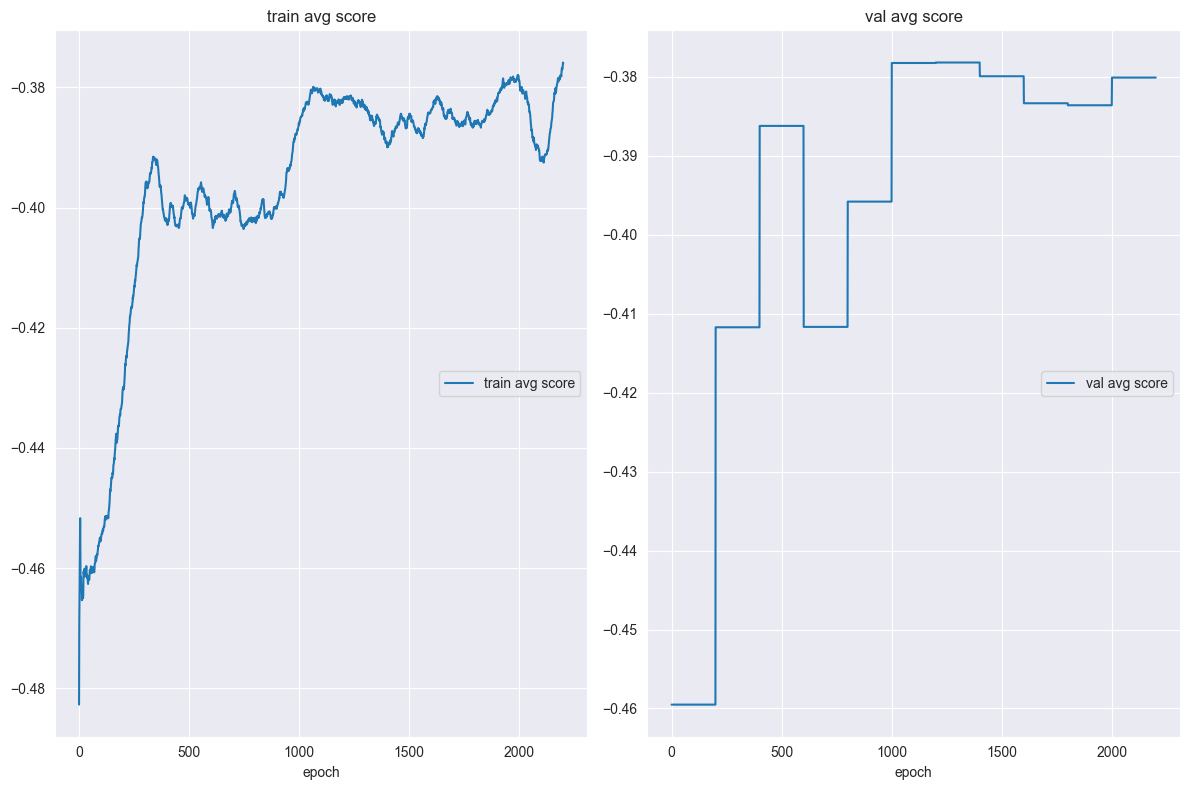

train avg score
	train avg score  	 (min:   -0.483, max:   -0.376, cur:   -0.376)
val avg score
	val avg score    	 (min:   -0.460, max:   -0.378, cur:   -0.380)


[I 2024-04-09 05:26:07,333] Trial 99 finished with value: -0.375893914091937 and parameters: {'num_mem_fill_eps': 1000, 'batch_size': 128, 'mem_capacity': 1500, 'update_frequency': 300, 'lr': 0.001, 'alpha': 0.001, 'gnn_depth': 3, 'hidden_size1': 32, 'hidden_size2': 32, 'n_step': 3}. Best is trial 89 with value: -0.3569911330580517.


EarlyStopping counter: 5 out of 5
Early stopping


In [158]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

In [165]:
study.best_params

{'num_mem_fill_eps': 1500,
 'batch_size': 128,
 'mem_capacity': 1500,
 'update_frequency': 300,
 'lr': 0.001,
 'alpha': 0.001,
 'gnn_depth': 3,
 'hidden_size1': 32,
 'hidden_size2': 64,
 'n_step': 3}

In [179]:
import matplotlib.pyplot as plt
import plotly

In [180]:
optuna.visualization.plot_optimization_history(study)


ImportError: Tried to import 'plotly' but failed. Please make sure that the package is installed correctly to use this feature. Actual error: No module named 'plotly'.

In [181]:
import pathlib
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
files = [str(f)+'\info.csv' for f in pathlib.Path('{}/results/hyp_search_2'.format(pathlib.Path.cwd())).iterdir() if f.is_dir()]

In [182]:
dataframes = []
for file in files:
    df = pd.read_csv(file) 
    
    df['source'] = file.split('\\')[-2]
    dataframes.append(df)

In [183]:
df_all = pd.concat(dataframes)
df_all

,ep_cnt,train_avg_score,val_avg_score,source
0,1000,-0.469850,-0.460502,cuda_0.001_4000_1000_0.99_128_1000_200_1.0_0.0...
1,1001,-0.465453,-0.460502,cuda_0.001_4000_1000_0.99_128_1000_200_1.0_0.0...
2,1002,-0.465823,-0.460502,cuda_0.001_4000_1000_0.99_128_1000_200_1.0_0.0...
3,1003,-0.467880,-0.460502,cuda_0.001_4000_1000_0.99_128_1000_200_1.0_0.0...
4,1004,-0.470073,-0.460502,cuda_0.001_4000_1000_0.99_128_1000_200_1.0_0.0...
...,...,...,...,...
1895,2395,-0.379952,-0.375532,cuda_0_4000_500_0.99_128_1500_400_1.0_0.05_400...
1896,2396,-0.379981,-0.375532,cuda_0_4000_500_0.99_128_1500_400_1.0_0.05_400...
1897,2397,-0.380415,-0.375532,cuda_0_4000_500_0.99_128_1500_400_1.0_0.05_400...
1898,2398,-0.380591,-0.375532,cuda_0_4000_500_0.99_128_1500_400_1.0_0.05_400...


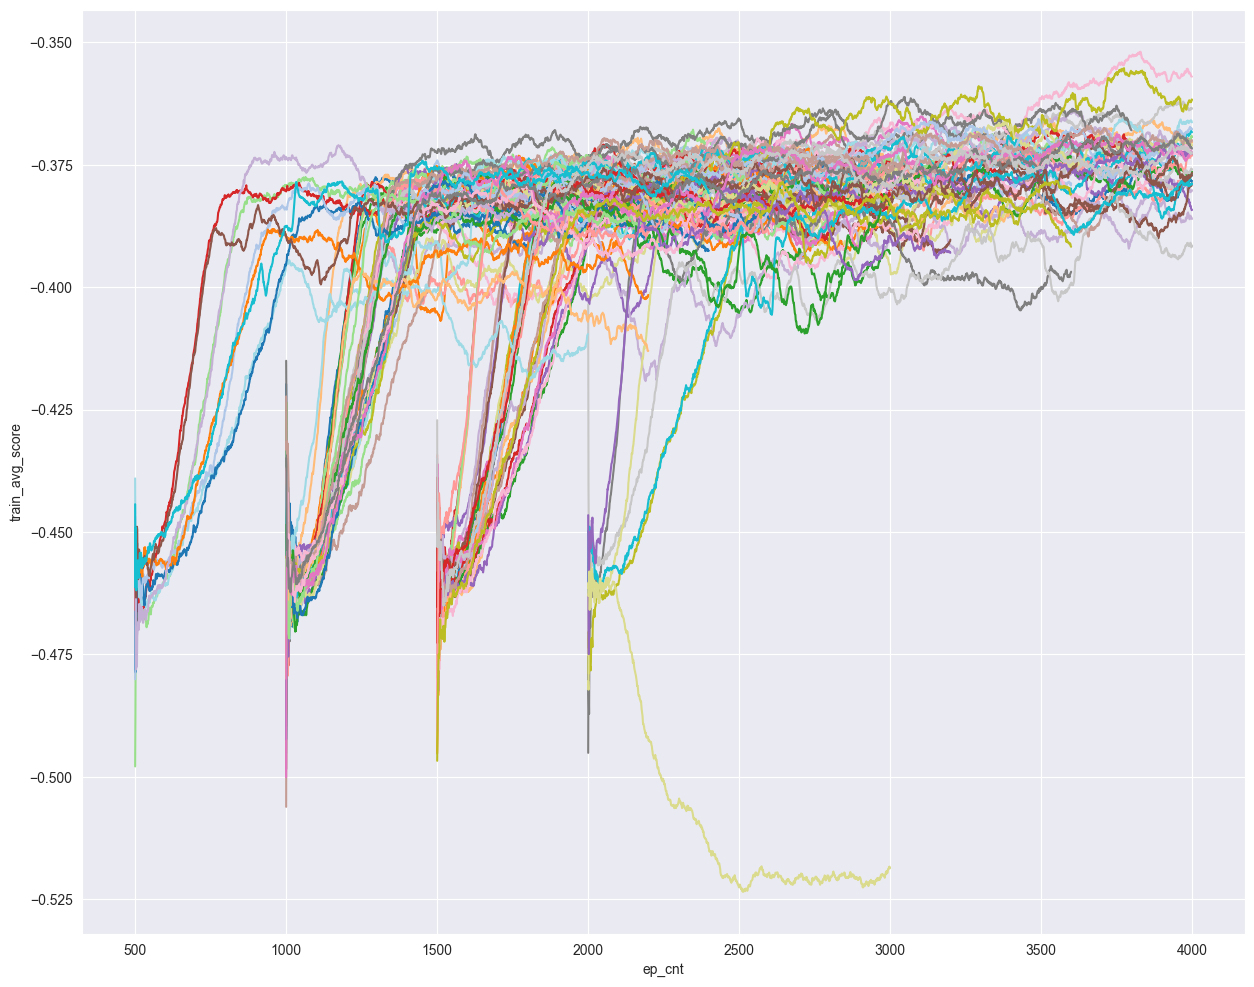

In [190]:
plt.figure(figsize=(15,12))
ax = sns.lineplot(df_all, y='train_avg_score', x='ep_cnt', hue='source', palette=sns.color_palette("tab20", 99), legend=False)
#sns.move_legend(ax, "upper right")